# Other microstructure datasets

Looking at other profiling datasets. The issue is that these are not long enough for an estimate of $⟨χ⟩$

In [2]:
%load_ext watermark
%matplotlib inline
%watermark -iv

import glob
import os

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from dcpy.oceans import read_osu_microstructure_mat
from IPython.display import Image

import eddydiff as ed
import xarray as xr

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

In [104]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:39775 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.39 GB


# TIWE

- \[ \] has negative values in dTdz_m
- \[ \] fix neutral density
- \[ \] think about plugging in a climatological mean dTdz

In [107]:
tiwe = (
    read_osu_microstructure_mat(
        "/home/deepak/datasets/microstructure/osu/tw91_sum.mat",
        coords={"depth", "time"},
    )
    .drop_vars(
        [
            "pmax",
            "castnumber",
            "AX_TILT",
            "AY_TILT",
            "AZ2",
            "C",
            "FALLSPD",
            "T1",
            "T2",
            "EPSILON1",
            "EPSILON2",
        ]
    )
    .cf.guess_coord_axis()
    .isel(time=slice(3, None))  # first three casts are bad
)

# EPSILON_clean is what we want
eps_old = tiwe.eps
tiwe["eps"] = tiwe.EPSILON_clean
tiwe.eps.attrs = eps_old.attrs
tiwe = tiwe.where(tiwe.eps.notnull())


# required by neutral_density
tiwe.coords["latitude"] = 0 * xr.ones_like(tiwe.time, dtype=int)
tiwe.coords["latitude"].attrs = {"standard_name": "latitude"}
tiwe.coords["longitude"] = -140 * xr.ones_like(tiwe.time, dtype=int)
tiwe.coords["longitude"].attrs = {"standard_name": "longitude"}

tiwe = ed.sections.add_ancillary_variables(tiwe)
tiwe

found variables named ('depth', 'pmax', 'starttime', 'endtime', 'time', 'castnumber', 'AX_TILT', 'AY_TILT', 'AZ2', 'C', 'CHI', 'EPSILON1', 'EPSILON2', 'FALLSPD', 'P', 'S', 'SIGMA', 'T', 'T1', 'T2', 'THETA', 'EPSILON', 'EPSILON_clean', 'readme')
Using coordinate vars with shapes: {3779: 'time', 250: 'depth'}
Setting starttime as attr.
Setting endtime as attr.
Setting readme as attr.


<xarray.Dataset>
Dimensions:             (depth: 250, time: 3776)
Coordinates:
  * depth               (depth) uint8 1 2 3 4 5 6 7 ... 245 246 247 248 249 250
  * time                (time) datetime64[ns] 1991-11-04T18:43:50 ... 1991-11...
    latitude            (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    longitude           (time) int64 -140 -140 -140 -140 ... -140 -140 -140 -140
    reference_pressure  int64 0
Data variables: (12/17)
    chi                 (depth, time) float64 nan nan nan nan ... nan nan nan
    pres                (depth, time) float64 nan nan nan nan ... nan nan nan
    salt                (depth, time) float64 nan nan nan nan ... nan nan nan
    pden                (depth, time) float64 nan nan nan nan ... nan nan nan
    T                   (depth, time) float64 nan nan nan nan ... nan nan nan
    theta               (depth, time) float64 nan nan nan nan ... nan nan nan
    ...                  ...
    chi_masked          (depth, time) float64 nan nan nan nan ... nan nan nan
    Krho                (depth, time) float64 nan nan nan nan ... nan nan nan
    KrhoTz              (depth, time) float64 nan nan nan nan ... nan nan nan
    eps_chi             (depth, time) float64 nan nan nan nan ... nan nan nan
    Kt                  (depth, time) float64 nan nan nan nan ... nan nan nan
    KtTz                (depth, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    starttime:  ['' '' '' ... 'Time:22:51:04 328   ' 'Time:22:57:35 328   '\n...
    endtime:    ['' '' '' ... 'Time:22:54:39 328   ' 'Time:23:01:10 328   '\n...
    readme:     ['EPSILON_clean cleaned using tw91_eps_chi_sum1.mat          ...

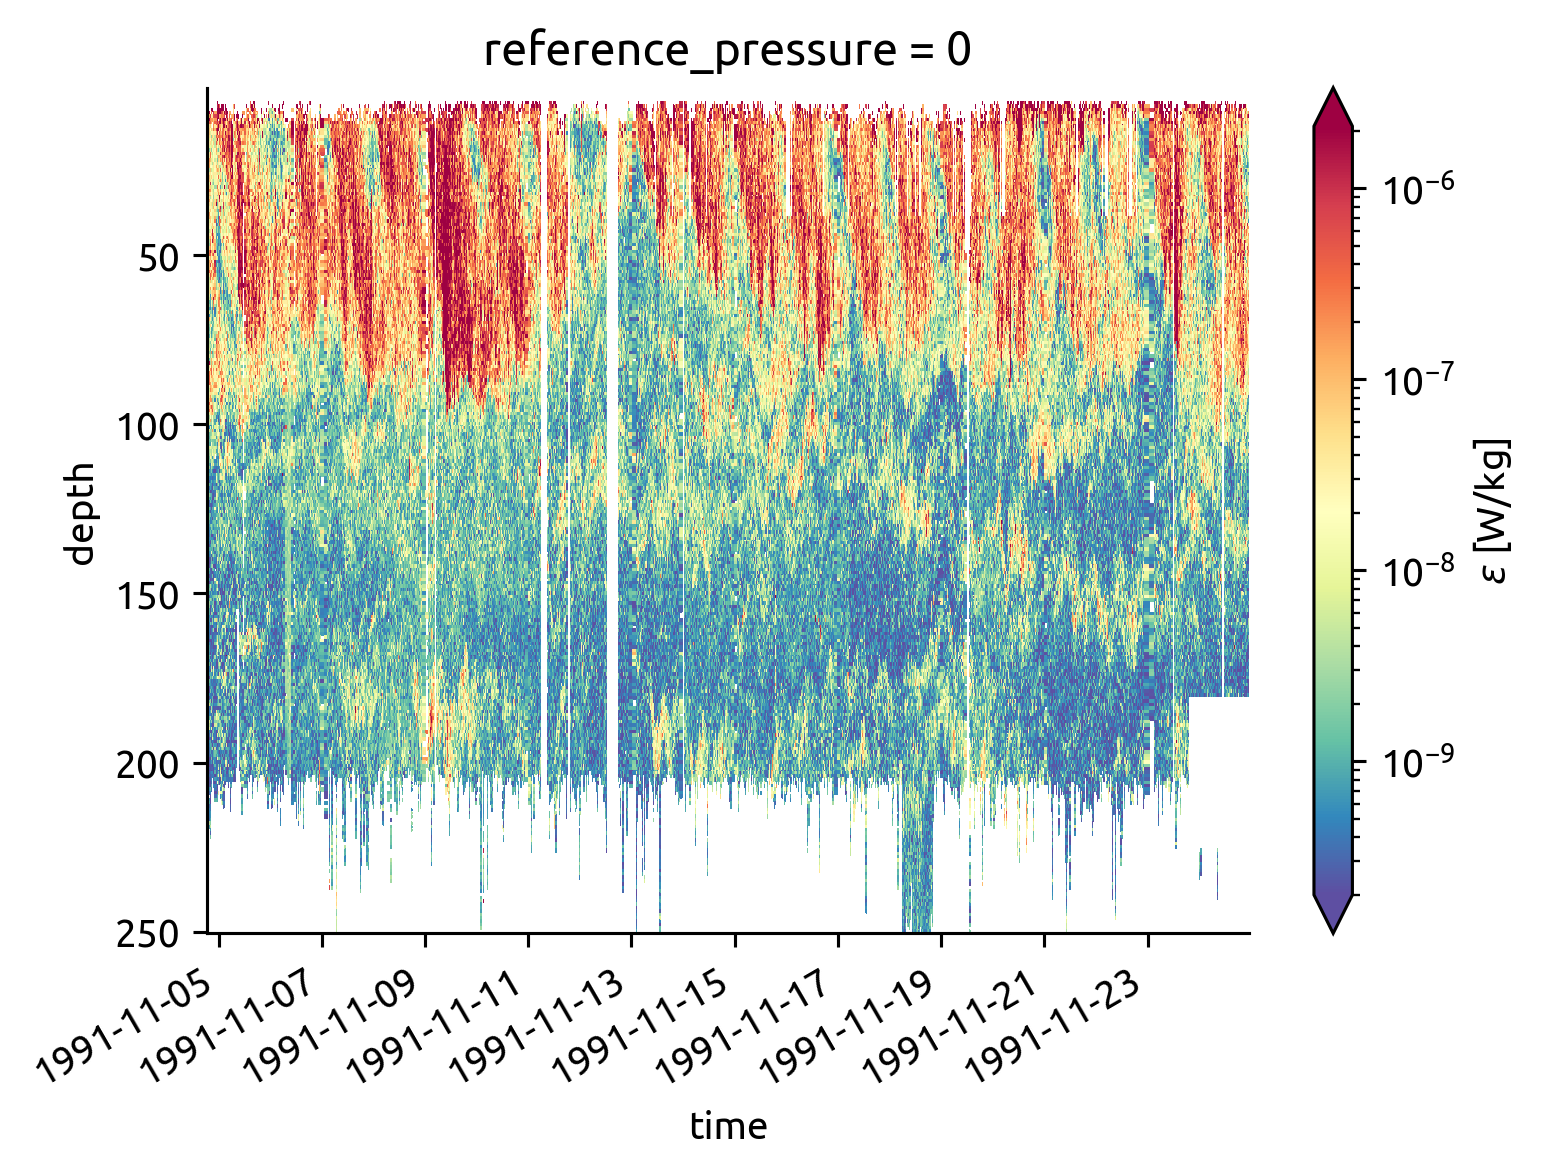

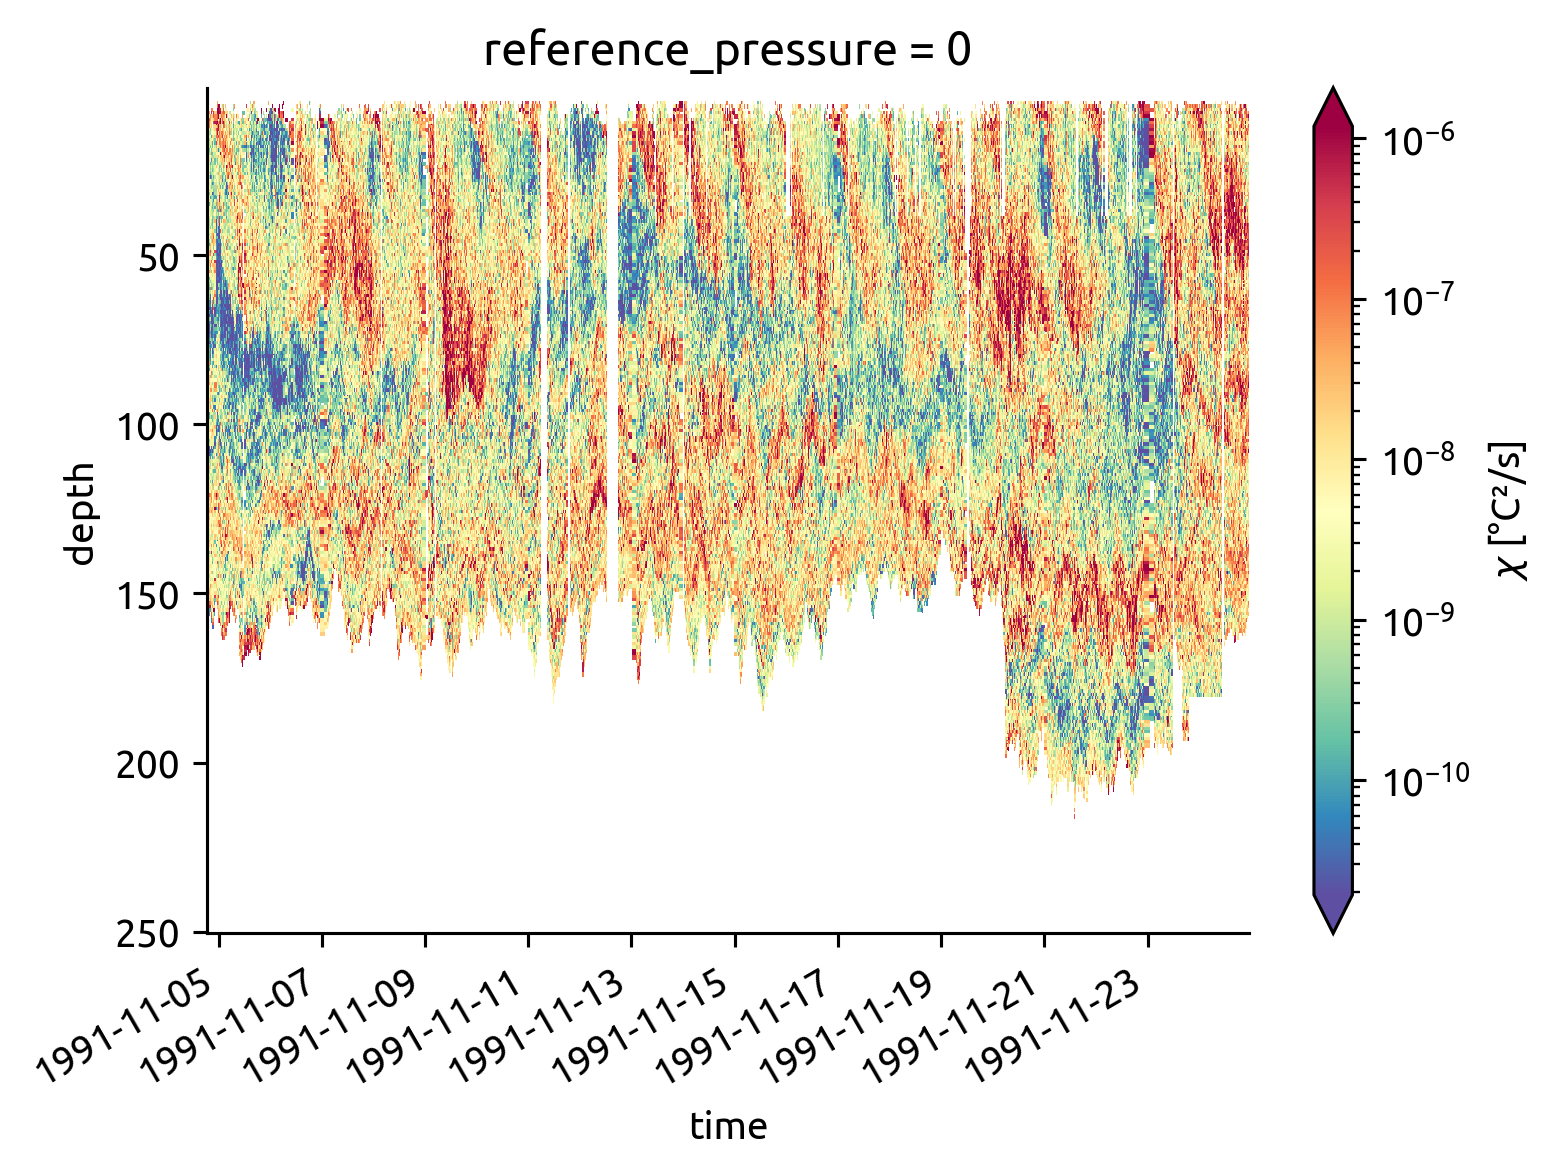

In [110]:
tiwe.eps.cf.plot(
    x="time", robust=True, norm=mpl.colors.LogNorm(), cmap=mpl.cm.Spectral_r
)
plt.figure()
tiwe.chi.cf.plot(
    x="time", robust=True, norm=mpl.colors.LogNorm(), cmap=mpl.cm.Spectral_r
)

In [112]:
bins = ed.sections.choose_bins(
    tiwe.cf["neutral_density"], depth_range=np.arange(25, 200, 10)
)
tiwedens = ed.sections.bin_average_vertical(tiwe, "neutral_density", bins)
tiwedens

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.Dataset>
Dimensions:             (gamma_n_bins: 17)
Coordinates:
  * gamma_n_bins        (gamma_n_bins) object (22.638, 22.665] ... (26.125, 2...
    pres                (gamma_n_bins) float64 31.88 34.43 44.73 ... 174.3 183.5
    reference_pressure  int64 0
Data variables: (12/20)
    chi                 (gamma_n_bins) float64 1.763e-07 1.198e-07 ... 1.973e-07
    salt                (gamma_n_bins) float64 34.94 34.97 35.03 ... 34.96 34.92
    pden                (gamma_n_bins) float64 1.023e+03 1.023e+03 ... 1.026e+03
    T                   (gamma_n_bins) float64 27.09 27.04 27.02 ... 14.67 14.0
    theta               (gamma_n_bins) float64 27.08 27.04 27.01 ... 14.65 13.98
    eps                 (gamma_n_bins) float64 9.901e-07 9.502e-07 ... 8.259e-09
    ...                  ...
    Kt                  (gamma_n_bins) float64 0.002371 0.002749 ... 4.557e-06
    KtTz                (gamma_n_bins) float64 7.481e-06 6.332e-06 ... 6.383e-07
    dTdz_m              (gamma_n_bins) float64 0.001672 0.001927 ... 0.02793
    N2_m                (gamma_n_bins) float64 7.768e-06 9.842e-06 ... 4.053e-05
    Krho_m              (gamma_n_bins) float64 0.02549 0.01931 ... 4.075e-05
    Kt_m                (gamma_n_bins) float64 0.03153 0.01613 ... 0.0001264
Attributes:
    starttime:  ['' '' '' ... 'Time:22:51:04 328   ' 'Time:22:57:35 328   '\n...
    endtime:    ['' '' '' ... 'Time:22:54:39 328   ' 'Time:23:01:10 328   '\n...
    readme:     ['EPSILON_clean cleaned using tw91_eps_chi_sum1.mat          ...

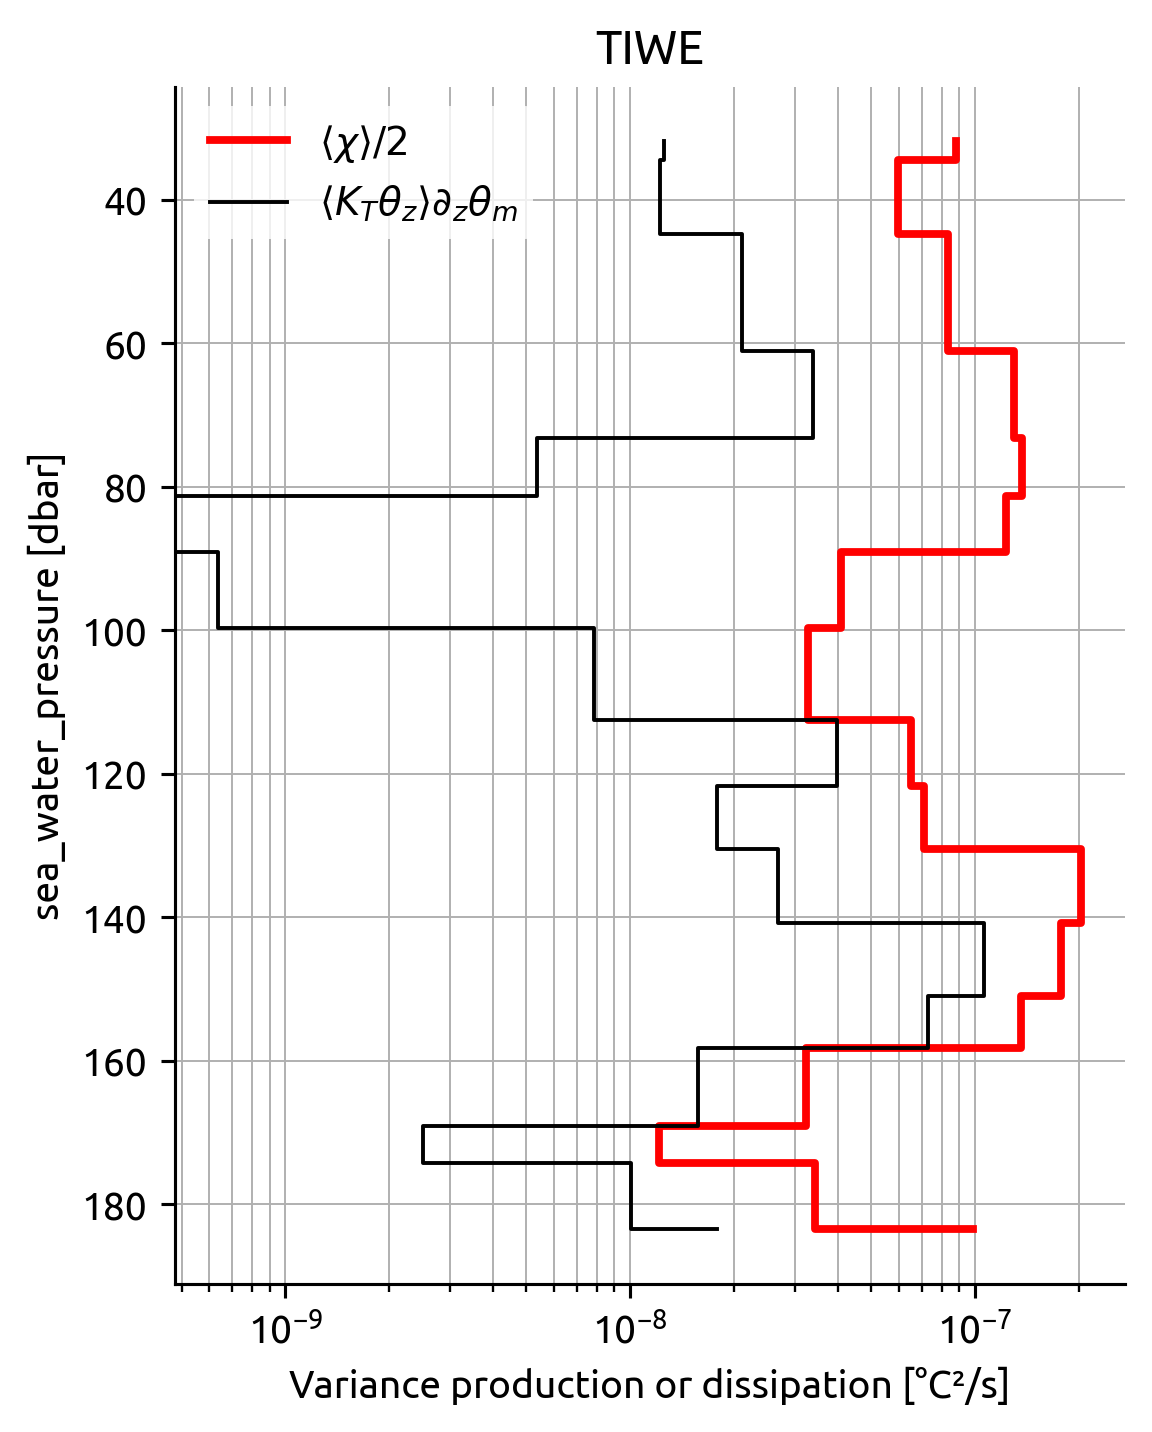

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


In [113]:
ed.sections.plot_var_prod_diss(tiwedens)
plt.title("TIWE")
plt.gcf().savefig("../images/tiwe-estimate.png")

### TIWE without χ

In [3]:
tiwe = read_osu_microstructure_mat(
    "/home/deepak/datasets/microstructure/osu/tw91_2009.mat",
    coords={"depth", "time", "u_depth"},
).drop_vars(["sal_depth", "theta_depth", "sigma_depth"])
tiwe

found variables named ('sal_depth', 'sal', 'sigma_depth', 'sigma', 'theta_depth', 'theta', 'u', 'v', 'u_depth', 'time', 'depth', 'eps', 'met', 'dTdz', 'nsq', 'dudz', 'dvdz', 'krho', 'jq')
Using coordinate vars with shapes: {200: 'depth', 34: 'u_depth', 915: 'time'}


/home/deepak/work/python/dcpy/dcpy/oceans.py:879: UserWarning: Skipping substructure met with fields ('E10', 'hl', 'hs', 'htot', 'jb', 'rl', 'rs', 'tair', 'tau', 'taux', 'tauy', 'tsfc', 'windir', 'windsp')
  warnings.warn(


<xarray.Dataset>
Dimensions:  (depth: 200, time: 915, u_depth: 34)
Coordinates:
  * u_depth  (u_depth) uint16 20 28 36 44 52 60 68 ... 244 252 260 268 276 284
  * time     (time) datetime64[ns] 1991-11-04T19:00:00 ... 1991-12-12T21:00:00
  * depth    (depth) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
Data variables:
    salt     (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    sigma    (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    theta    (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    u        (u_depth, time) float64 -0.0462 -0.0947 -0.0951 ... 0.039 0.04542
    v        (u_depth, time) float64 -0.0008 0.0042 0.0028 ... -0.05321 -0.04629
    eps      (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    dTdz     (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    N2       (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    dudz     (u_depth, time) float64 -0.001575 0.001812 ... -0.002354 -0.002656
    dvdz     (u_depth, time) float64 0.000275 0.00035 ... -0.002323 -0.001771
    Krho     (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Jq       (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan

# TROPIC HEAT: no χ

In [4]:
th84 = read_osu_microstructure_mat(
    "/home/deepak/datasets/microstructure/osu/th84_timeseries_2009.mat"
)
th84

found variables named ('time', 'lat', 'lon', 'wspeed', 'T', 'S', 'SIGT', 'U', 'V', 'EPS', 'depth', 'readme', 'dTdz', 'dsigdz', 'nsq', 'dudz', 'dvdz')
Using coordinate vars with shapes: {60: 'depth', 288: 'time'}
Setting readme as attr.


<xarray.Dataset>
Dimensions:  (depth: 60, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1984-11-19T20:30:02 ... NaT
  * depth    (depth) float64 3.1 7.1 11.1 15.1 19.1 ... 227.1 231.1 235.1 239.1
Data variables: (12/14)
    lat      (time) float64 -0.0355 -0.012 -0.0043 ... 0.0028 -0.0127 nan
    lon      (time) float64 140.0 140.0 140.0 140.0 ... 140.0 140.0 140.0 nan
    wspeed   (time) float64 7.54 6.93 6.71 6.57 6.37 ... 8.635 8.625 8.445 nan
    theta    (depth, time) float64 24.16 24.18 24.24 nan ... nan nan nan nan
    salt     (depth, time) float64 34.81 34.82 34.81 nan ... nan nan nan nan
    SIGT     (depth, time) float64 23.46 23.45 23.43 nan ... nan nan nan nan
    ...       ...
    eps      (depth, time) float64 nan nan nan nan 1.897e-05 ... nan nan nan nan
    dTdz     (depth, time) float64 -0.01362 -0.0238 -0.03795 nan ... nan nan nan
    dsigdz   (depth, time) float64 0.00415 0.006875 0.01108 nan ... nan nan nan
    N2       (depth, time) float64 3.976e-05 6.586e-05 0.0001061 ... nan nan nan
    dudz     (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    dvdz     (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    readme:   ['this file is compiled from a binary          '\n 'Fortran fil...

In [115]:
dirname = "~/work/datasets/microstructure/tropic_heat_microstructure/"


def preprocess(ds):
    import cf_xarray

    renamer = {
        "latitude": "latitude",
        "longitude": "longitude",
        "depth": "depth",
        "time": "time",
        "sea_water_salinity": "salt",
        "sea_water_temperature": "temp",
        "sea_water_pressure": "pres",
        "ocean_turbulent_kinetic_energy_dissipation_rate": "eps",
    }

    ds = (
        ds.squeeze()
        # .cf.rename_dims(depth="z")
        .cf.reset_coords(["longitude", "time"])
        .cf.expand_dims("latitude")
        .cf.rename(renamer)
    )
    ds.depth.attrs["positive"] = "down"

    masks = dict(salt=(20, 40), temp=(10, 40), eps=(1e-14, 1))
    for var, (vmin, vmax) in masks.items():
        ds[var] = ds[var].where((ds[var] > vmin) & (ds[var] < vmax))
    return ds


th = xr.open_mfdataset(
    f"{dirname}/tropic_heat_*.nc", parallel=True, preprocess=preprocess
)
th

<xarray.Dataset>
Dimensions:    (depth: 70, latitude: 84)
Coordinates:
  * latitude   (latitude) float64 -2.945 -2.88 -2.812 ... 2.781 2.848 2.912
  * depth      (depth) float64 3.1 7.1 11.1 15.1 ... 267.1 271.1 275.1 279.1
Data variables:
    longitude  (latitude) float64 -140.0 -140.2 -140.2 ... -140.3 -140.3 -140.3
    time       (latitude) datetime64[ns] 1984-11-18T18:28:48.000001664 ... 19...
    eps        (latitude, depth) float64 dask.array<chunksize=(1, 70), meta=np.ndarray>
    pres       (latitude, depth) float64 dask.array<chunksize=(1, 70), meta=np.ndarray>
    salt       (latitude, depth) float64 dask.array<chunksize=(1, 70), meta=np.ndarray>
    temp       (latitude, depth) float64 dask.array<chunksize=(1, 70), meta=np.ndarray>
Attributes: (12/14)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               TROPIC HEAT
    expocode:              32WC19841115
    cast_number:           1.0
    title:                 Microstructure profiler data from the ship Wecoma ...
    ...                    ...
    longitude:             -140.2536
    chief_scientist:       James N. Moum
    data_originator:       James N. Moum
    institution:           OSU
    data_assembly_center:  CCHDO
    references:            Moum_1986_JPO, DOI: http://dx.doi.org/10.1175/1520...

In [ ]:
th.eps.sel(depth=slice(130)).cf.plot(robust=True, norm=mpl.colors.LogNorm())

## EQ08 / EQUIX

In [3]:
equix = (
    read_osu_microstructure_mat(
        "/home/deepak/work/datasets/microstructure/osu/eq08_sum_deglitched.mat",
        rename=True,
    )
    .cf.guess_coord_axis()
    .set_coords(["lat", "lon"])
)
equix = ed.sections.add_ancillary_variables(equix)

# take out ML
equix = equix.sel(depth=slice(25, None))

equix = equix.cf.set_coords(["latitude", "longitude"])
del equix.attrs["direction"]
equix

found variables named ('depth', 'pmax', 'starttime', 'endtime', 'direction', 'lon', 'lat', 'time', 'castnumber', 'AX_TILT', 'AY_TILT', 'AZ2', 'C', 'CHI', 'DRHODZ', 'DTDZ', 'EPSILON', 'EPSILON1', 'EPSILON2', 'FALLSPD', 'MHT', 'N2', 'P', 'S', 'SCAT', 'SIGMA', 'SIGMA_ORDER', 'T', 'THETA', 'TP', 'VARAZ', 'VARLT')
Using coordinate vars with shapes: {200: 'depth', 2624: 'time'}
Setting starttime as attr.
Setting endtime as attr.
Setting direction as attr.


<xarray.Dataset>
Dimensions:      (depth: 176, time: 2624)
Coordinates:
  * depth        (depth) uint8 25 26 27 28 29 30 31 ... 195 196 197 198 199 200
    lon          (time) float64 -139.9 -139.9 -139.9 ... -139.9 -139.9 -139.9
    lat          (time) float64 0.06246 0.0622 0.06263 ... 0.06317 0.06341
  * time         (time) datetime64[ns] 2008-10-24T20:36:23 ... 2008-11-08T19:...
Data variables: (12/32)
    pmax         (time) float64 205.9 199.0 202.0 202.0 ... 202.0 221.1 203.9
    castnumber   (time) uint16 16 17 18 19 20 21 ... 2664 2665 2666 2667 2668
    AX_TILT      (depth, time) float64 0.559 0.665 1.059 ... 0.7031 4.232 1.28
    AY_TILT      (depth, time) float64 -4.616 -4.041 -3.503 ... -2.121 0.05032
    AZ2          (depth, time) float64 1.232e-05 4.286e-07 ... 3.208e-06
    C            (depth, time) float64 5.258 5.261 5.262 ... 4.135 4.137 4.164
    ...           ...
    chi_masked   (depth, time) float64 7.47e-09 1.045e-08 ... 9.245e-09
    Krho         (depth, time) float64 0.0002031 0.001235 ... 2.642e-05 9.09e-06
    KrhoTz       (depth, time) float64 -7.565e-07 -5.011e-06 ... -4.646e-07
    eps_chi      (depth, time) float64 3.796e-08 2.623e-08 ... 5.132e-10
    Kt           (depth, time) float64 0.0002691 0.0003172 ... 4.26e-07 1.77e-06
    KtTz         (depth, time) float64 -1.003e-06 -1.287e-06 ... -9.044e-08
Attributes:
    starttime:  ['Time:20:34:29 298   ' 'Time:20:42:18 298   ' 'Time:20:52:14...
    endtime:    ['Time:20:38:29 298   ' 'Time:20:46:29 298   ' 'Time:20:56:29...

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:1385: AccessorRegistrationWarning: registration of accessor <class 'cf_xarray.accessor.CFDatasetAccessor'> under name 'cf' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("cf")
/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:1667: AccessorRegistrationWarning: registration of accessor <class 'cf_xarray.accessor.CFDataArrayAccessor'> under name 'cf' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor("cf")


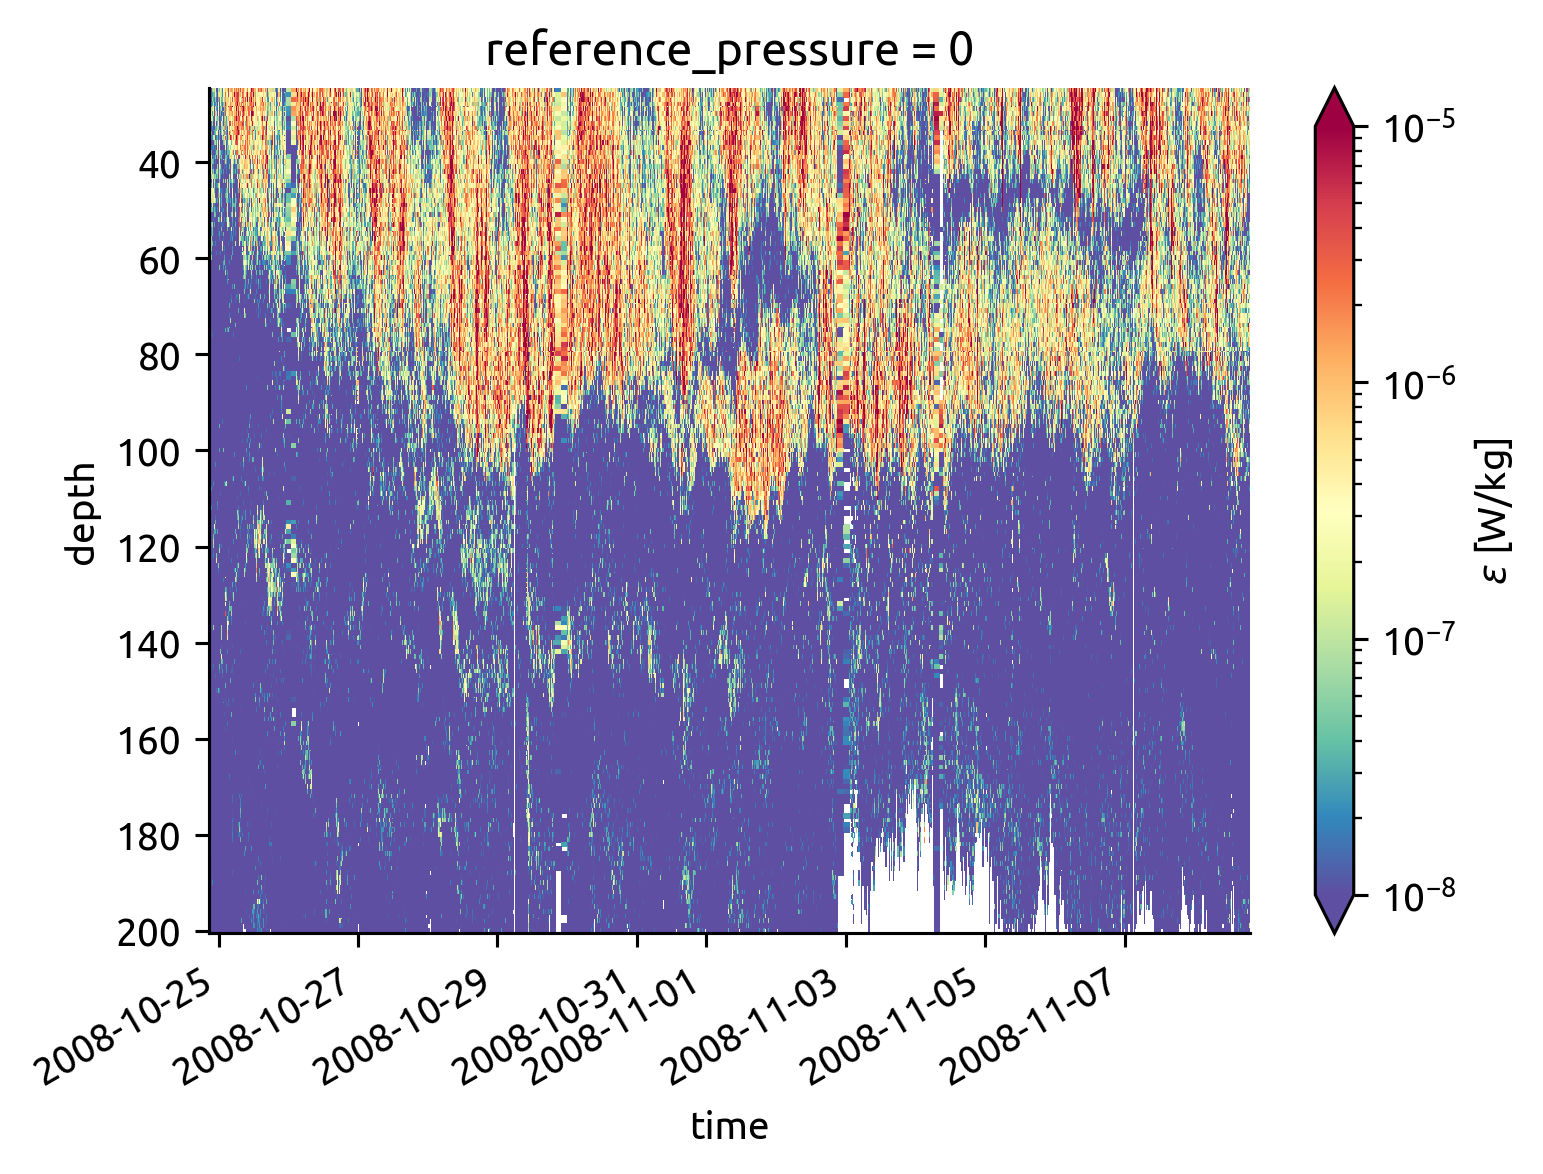

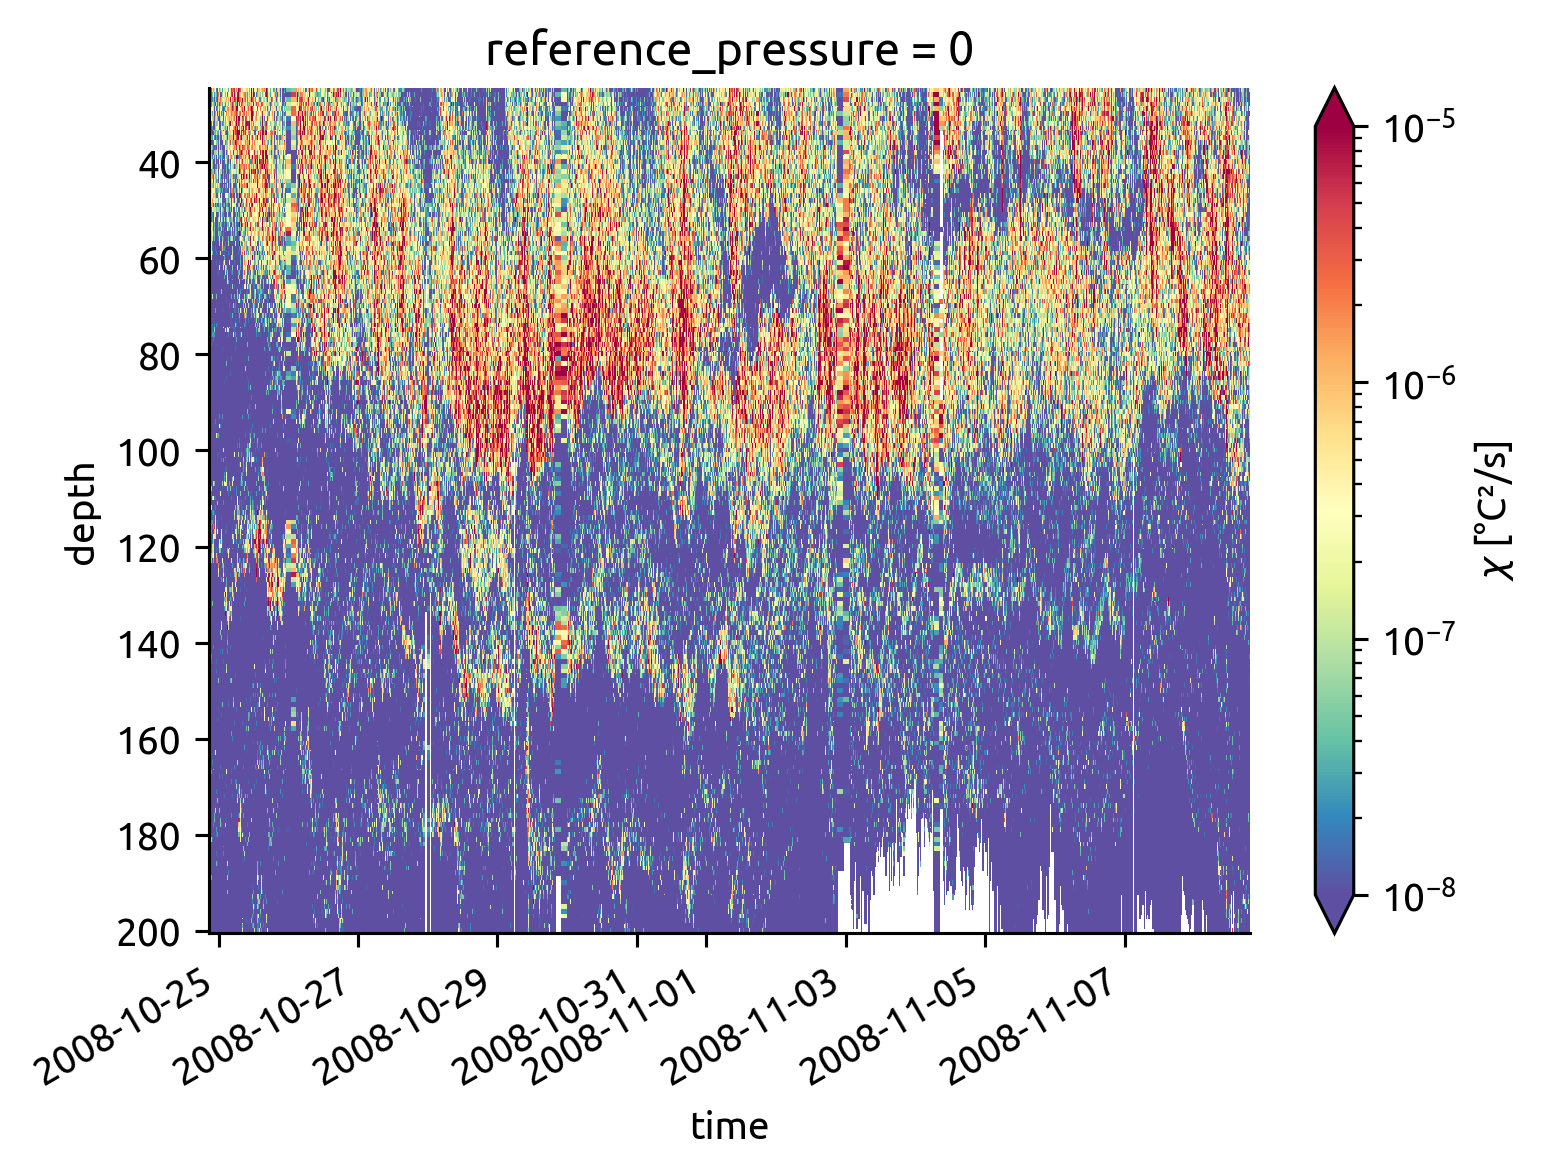

In [31]:
equix.eps.cf.plot(
    x="time", robust=True, norm=mpl.colors.LogNorm(1e-8, 1e-5), cmap=mpl.cm.Spectral_r
)

plt.figure()
equix.chi.cf.plot(
    x="time", robust=True, norm=mpl.colors.LogNorm(1e-8, 1e-5), cmap=mpl.cm.Spectral_r
)

In [32]:
bins = ed.sections.choose_bins(
    equix.cf["neutral_density"], depth_range=np.arange(25, 200, 10)
)
eqdens = ed.sections.bin_average_vertical(equix, "neutral_density", bins)

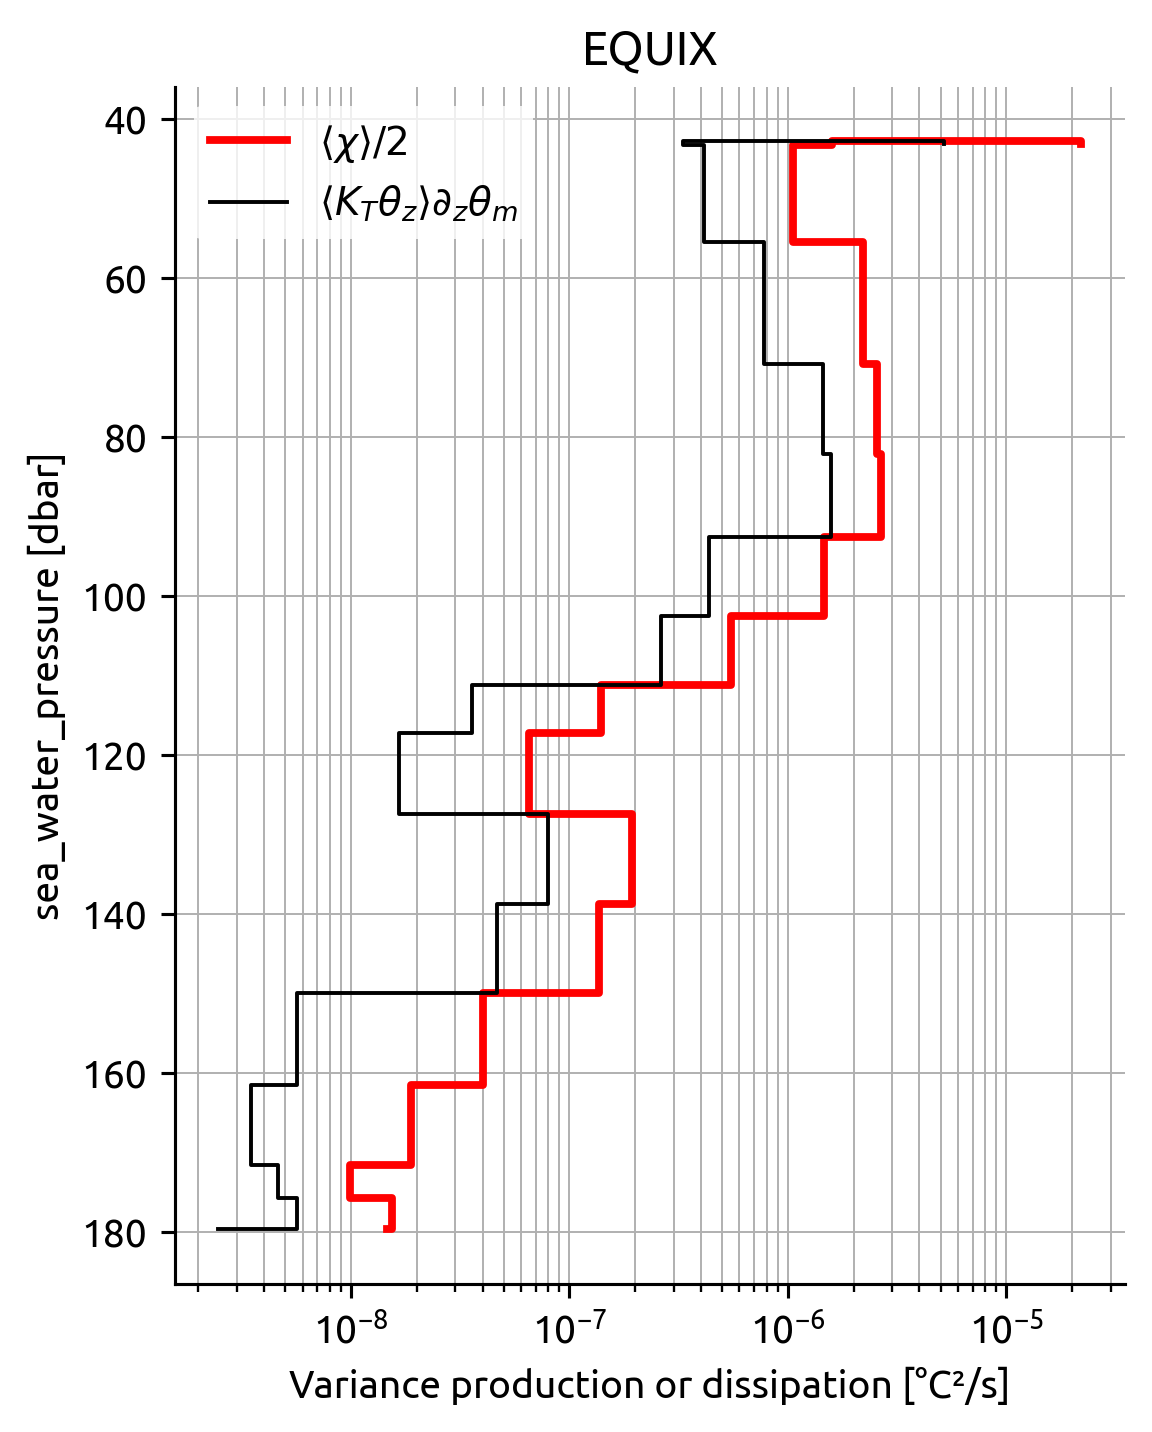

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [18]:
ed.sections.plot_var_prod_diss(eqdens)
plt.title("EQUIX")
plt.gcf().savefig("../images/equix-estimate.png")

## MIXET